# Dimensionsreduzierung

In [164]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

In [165]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

# 1. Anwendung von Algorithmen zur Reduktionsreduzierung auf originalen Daten

## 1.1 Vorbereitung des Datensets für Algorithmen zur Reduktionsreduzierung

Damit die verwendeten Algorithmen zur Reduktionsreduzierung die Daten korrekt verarbeiten können, müssen ausschließlich numerische Features übergeben werden. Mithilfe des One-Hot-Encodings im Preprocessing wurden jedoch sowohl die demographischen Angaben wie Studiengang und Geschlecht als auch die Freitextfelder "Lieblingssportart", "Lieblingsessen" & "Lieblingsmusiker*in" (sowie das neue Feature "Genre") bereits in numerische Features übersetzt. Wie die Übersicht zeigt, sind in den vorverarbeiteten Daten somit bereits nur noch numerische Daten enthalten, sodass diesbezüglich keine weiteren Bearbeitungen notwendig sind.

In [166]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 82 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype
---  ------                                                                                                                      --------------  -----
 0   Alter                                                                                                                       62 non-null     int64
 1   Als wie sportlich würdest du dich einschätzen?                                                                              62 non-null     int64
 2   Welche Rolle spielt für dich gesunde Ernährung?                                                                             62 non-null     int64
 3   Wie gerne gehst du Essen oder Trinken?                                                                                      62 non-null  

Eine Skalierung der Daten ist notwendig, damit die Clustering-Algorithmen keine verschiedenen Zahlenräume bei der Berechnung nutzen, die z. B. Features mit höheren Werten fälschlicherweise als "relevanter" erscheinen lassen. Zwar sind aufgrund der Form der Datenerhebung viele der Features auf Werte von 1-5 beschränkt; Einige Features wie z. B. das Alter lassen aber einen größeren Zahlenbereich zu, sodass eine Sklarierung durchaus sinnvoll bleibt. Außerdem bleibt das Vorgehen somit auch bei der (nachträglichen) Erweiterung der Features und/oder deren Werte anwendbar.

In [167]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_encoded), columns=columns_encoded)

data_scaled.shape

(62, 82)

## 1.1 ("Standard") PCA

Die Hauptkomponentenanalyse (PCA) ist eine der verbreitetsten Verfahren zur Reduktionsreduzierung und versucht über die Berechnung der Eigenvektoren einer Kovarianzmatrix lineare Zusammenhänge in den Features eines Datensets zu erkennen. Insofern die Daten lineare Zusammenhänge aufweisen, liefert PCA in vergleichsweise schneller Berechnungszeit gute Ergebnisse. Außerdem ist PCA vergleichsweise "einfach" zu benutzen, da neben der Anzahl der zu berechnenden Dimensionen (n_components) keine weiteren Parameter angegeben werden müssen.

Da es sich bei dem Datenset um reelle Daten (und keine "Modelldaten") handelt, und zudem vergleichsweise wenig Datenpunkte enthalten sind, ist vorstellbar, dass PCA das Datenset nur bedingt gut verarbeiten kann, da (lineare) Zusammenhänge intuitiv nur eingeschränkt sichtbar werden können. Da die Daten zur Visualisierung in einem 2D-Scatterplot dargestellt werden sollen, ist die Wahl von n_components=2 naheliegend. Theoretisch könnten zusätzlich ein paar wenige weitere Dimensionen (z. B. über Größe, Farbe, etc.) dargestellt werden; Da durch andere Algorithmen aber im Folgenden ohnehin noch weitere Optionen zur Dimensionsreduzierung untersucht werden, wird hier ausschließlich die Reduktion auf zwei Dimensionen untersucht. 

In [168]:
# Angabe der gewünschten Dimensionen
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled)
X_pca.shape

(62, 2)

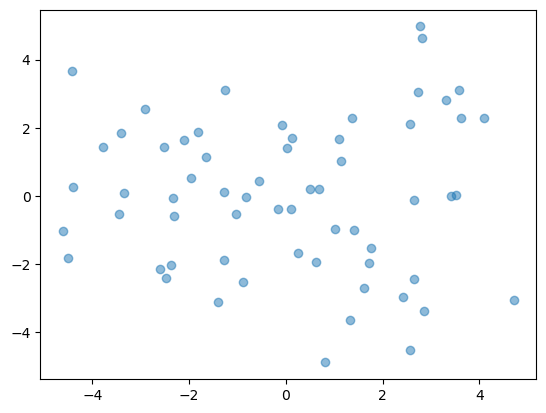

In [169]:
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)

In [170]:
pca.explained_variance_ratio_

array([0.07503312, 0.06022329])

### Ergebnisse / Beobachtungen

In der Visualisierung der durch PCA reduzierten Daten ist zu erkennen, dass diese sich recht gleichmäßig auf den Achsen bzw. den Zahlenraum der Features verteilen. Gleichzeitig sind keine unmittelbaren Cluster zu erkennen. Dieses Ergebnis passt zu den zuvor begründeten Erwartungen, bei denen aufgrund der geringen Anzahl der Datenpunkte keine offensichtliche Cluster o. ä. vermutet wurden.

Ob die Dimensionsreduzierung für die weitere Untersuchung "brauchbar" ist, lässt sich rein aus der Visualisierung nicht sagen, da es sich bei den berechneten Features um Abstraktionen handelt, die nicht als "richtig" oder "falsch" interpretierbar sind. Lediglich die "explained variance ratio" weist mit Werten von 0.1 darauf hin, dass verhältnismäßg viel Information durch die Reduktion verloren geht. Aufgrund des Ziels, die Daten auf zwei Dimensionen abzubilden, kann dieser Wert nicht z. B. durch Erhöhung der Anzahl an Dimensionen (n_components) erhöht werden und muss vorerst hingenommen werden.

## 1.2 Kernel PCA

Kernel-PCA erlaubt als Variante von PCA das Festlegen von weiteren Parametern, wie z. B. eines "Kernels", der zur Berechnung genutzt wird. Hierdurch können auch nicht-lineare Strukturen erkannt und möglichst derart in die berechneten Dimensionen bzw. Features integriert werden, das der Informationsgehalt im Vergleich zu den Ausgangsdaten größer bleibt. Unter der Annahme, dass das Datenset aufgrund seiner Größe - wenn -  eher nicht-lineare Zusammenhänge aufweisen, sollte Kernel PCA zielführerende Ergebnisse als "Standard" PCA liefern.

Eine automatische "GridSearch" zum Finden geeigneter Parameter ist nicht möglich, da intuitiv nicht klar ist, wie die "Scoring"-Funktion gewählt werden kann bzw. wonach die reduzierten Daten bewertet werden können. Stattdessen wird mithilfe einer Hilfsfunktion  die Berechnungserbnisse von verschiedenen Kernel PCA-Instanzen mit verschiedenen Parameterwerten zusammen ausgegeben, um diese visuell (z. B. das Maß der Streuung, erkennbare Cluster,...) miteinander vergleichen zu können. 

Für die Eingabe werden die Parameter wie folgt gewählt:
- n_components: Die Anzahl der zu berechnenden Dimensionen wird auf zwei beschränkt (n_components=2), da die Ausgabe in einem 2D-Plot erfolgen soll.
- kernel: Wahl von drei populären Kernels "rbf", "poly" & "sigmoid". Der Kernel "linear" würde z. B. zur Berechnung im Sinne eines "Standard"-PCA Modells führen.
- gamma: Da der Wert per Default als "1/Anzahl features" festgelegt wird, werden als mögliche weitere Werte solche getestet, die im unmittelbaren Umfeld dieses Wertes liegen (ca. 0.012 bei der gegebenen Featureanzahl von 82).

In [171]:
# Input:
#   - results:  Computation results as an array of tuples with the form [("<<plot title>>", [<<2-dimensional array>>])],
#               where the 2-dimensional array describes the x- & y-position of each data point & the title should describe the chosen parameter-values
#   - figsize_columns: number of columns which are used to layout the plotted graphs. The number of rows is depending on the number of 'results' and the given 'figsize_columns'.
#   - figsize (optional): Adjusts the width/height of the individual graphs, in case the scaling is different for different computations
# Ouput: The plotted graphs which represent the given data from 'results'
import math

def display_reduction_results(results, figsize_columns, figsize=(15, 15)):
    figsize_rows = math.ceil(len(results) / figsize_columns)
    fig, ax = plt.subplots(figsize_rows, figsize_columns, figsize=figsize)
    fig.tight_layout(pad=3)

    for i in range(len(results)):
        plt.subplot(figsize_rows, figsize_columns, i+1).set_title(results[i][0])
        
        if len(results[i][1][0]) <= 2:
            plt.subplot(figsize_rows, figsize_columns, i+1).scatter(results[i][1][:,0], results[i][1][:,1], alpha=0.4)
        else:
            plt.subplot(figsize_rows, figsize_columns, i+1).scatter(results[i][1][:,0], results[i][1][:,1], c=results[i][1][:,2], alpha=0.4)

In [172]:
n_components = [2]
gammas = [None, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.5, 0.6]
kernels = ["rbf", "poly", "sigmoid"]

kpca_results = []

for kernel in kernels:
    for gamma in gammas:
        for components in n_components:
            kpca = KernelPCA(n_components=components, gamma=gamma, kernel=kernel).fit_transform(data_scaled)
            parameter_string = "Comp: " + str(components) + ", Gamma: " + str(gamma) + ", Kernel: " + str(kernel)
            kpca_results.append((parameter_string, kpca))

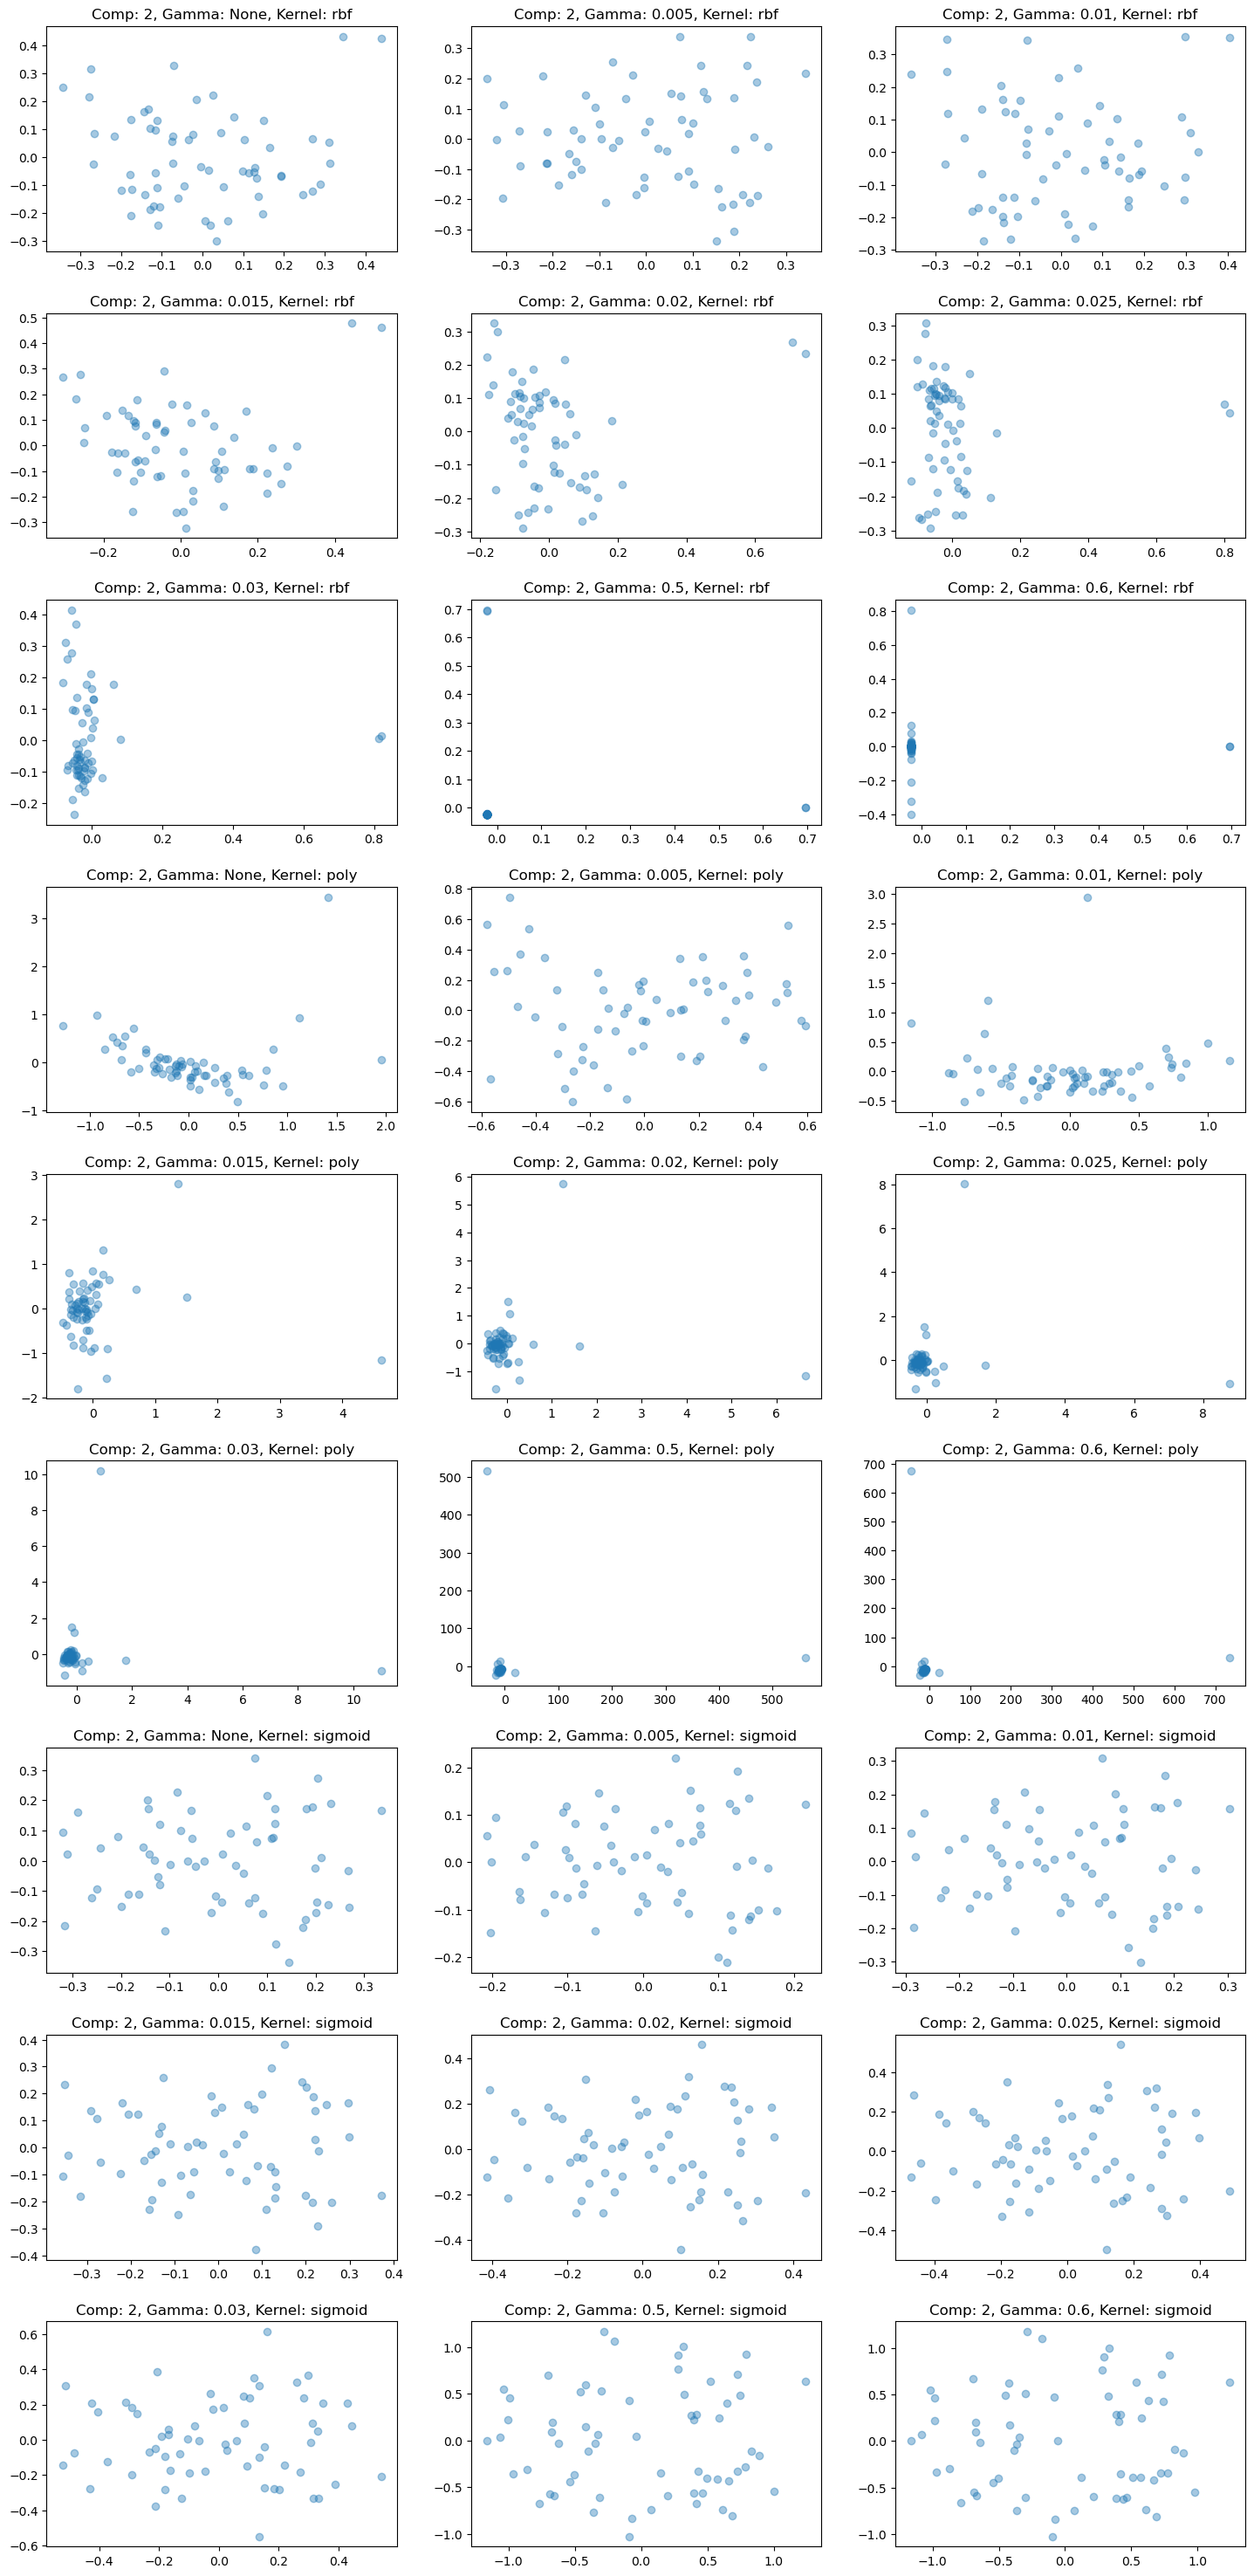

In [173]:
display_reduction_results(kpca_results, 3, (15, 30))

### Ergebnisse / Beobachtungen
Im Vergleich der Plots ist schnell zu erkennen, dass einige Paramterwerte bzw. Kombinationen wie z. B. gamma-Werte ab 0.5 für den "rbf"-Kernel oder gamma-Werte ab 0.02 für den "poly"-Kernel zu dichteren Clustern führen. Weiterhin sind in diesen Plots Ausreißer zu erkennen (insbesondere beim "poly"-Kernel), bei denen diese Ausreißer vor der weiteren Untersuchung manuell entfernt werden sollten, da hierdruch die Verteilung der anderen Datenpunkte nicht mehr eindeutig zu erkennen ist. Da die Daten aber insgesamt offensichtlich zu stark "komprimieren", sind diese für die weitere Untersuchung eher ungeeignet.

Ansonsten scheinen die übrigen Parameter-Kombinationen die Daten einigermaßen gleich in dem jeweiligen Zahlenraum zu verteilen. Rein aus der Darstellung lässt sich also keine Präferenz für eine bestimmte Parameterkombination erkennen. Die Eignung würde sich erst in weiteren Untersuchung, z. B. der Einfärbung gefundener Cluster, zeigen.

## 1.3 t-SNE

Analog zu Kernel PCA können auch mit t-SNE bei der Dimensionsreduzierung nicht-lineare Strukturen erkannt werden, wodurch auch hier intuitiv bessere Ergebnisse bzgl. der Bewahrung des Informationsgehalts der Urspungsdaten erzielt werden könnten. Im Gegensatz zu (Kernel) PCA gilt t-SNE jedoch als komplexer in der Berechnung und ähnlich zu Kernel PCA Parameter, die die Berechnung beeinflussen können. Aufgrund der geringen Anzahl an Datenpunkten kann die erhöhte Komplexität des Algorithmus bei der Berechnung vorerst vernachlässigt werden. Auch die Vorschaltung von PCA mit anschließendem t-SNE zur Steigerung der Performanz wurde für diesen Datensatz als nicht nötig empfunden.

Analog zum Vorgehen der Parametersuche für Kernel PCA werden im Folgenden einige Berechnungen von t-SNE mit verschiedenen Werten für den Parameter "perplexity" ausgegeben, um diese miteinander vergleichen zu können. Laut der offiziellen [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) sollte der "perplexity"-Wert zwischen 5 und 50 gewählt werden. Da der Default-Wert für den "perplexity"-Parameter bei 30 liegt, werden insbesondere Werte in der Umgebung dieses Richtwertes untersucht und zusätzlich Randwerte  zum Vergleich mit den "Extremwerten" berechnet.

In [174]:
perplexities = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]

tsne_results = []

for perplexity in perplexities:
    tsne = TSNE(perplexity=perplexity, random_state=0).fit_transform(data_scaled)
    parameter_string = "Perplexity: " + str(perplexity)
    tsne_results.append((parameter_string, tsne))

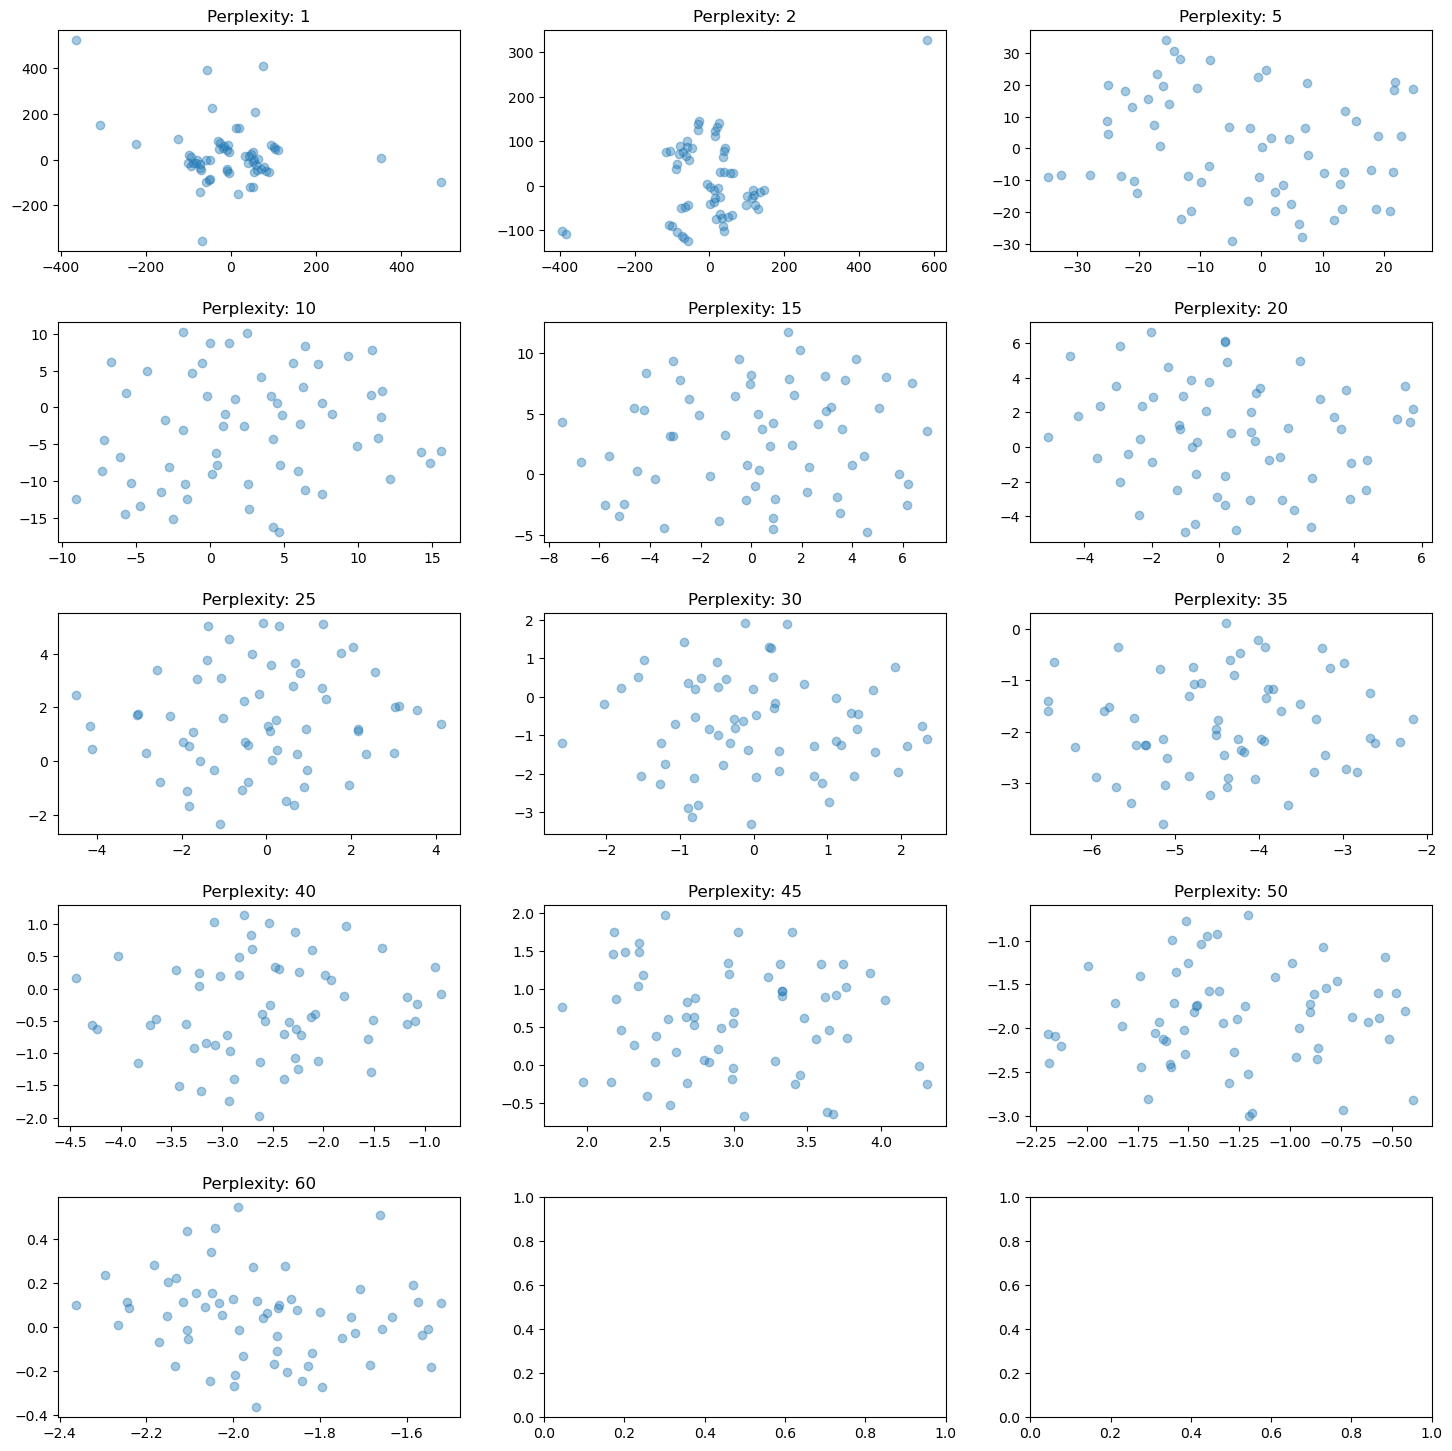

In [175]:
display_reduction_results(tsne_results, 3)

### Ergebnisse / Beobachtungen
- Insbesondere bei niedrigeren "perplexity"-Werten sind schon auf den ersten Blick eindeutige Cluster zu erkennen. Wie jedoch bspw. in diesem [Online Artikel](https://distill.pub/2016/misread-tsne/) beschrieben, ergeben sich solche Cluster lediglich durch die starke Gewichtung lokaler Strukturen im Algorithmus und haben für die praktische Auswertung so gut wie keine Bedeutung (*"[...] those “clumps” aren’t meaningful. If you look back at previous examples, low perplexity values often lead to this kind of distribution. Recognizing these clumps as random noise is an important part of reading t-SNE plots. [...]"*). Da beim Graphen des "perplexity"-Werts 30 zumindest kleinere Strukturen erkennbar sind, kann der Default-Wert für "perplexity" als verwendbar angesehen werden (solange keine nähere Untersuchung die Eignung wiederspricht).

## 1.4 Vergleich der Ergebnisse

Es lässt sich feststellen, dass alle drei Verfahren grundsätzlich plausibel aussehende Dimensionsreduzierungen durchführen können, die die Datenpunkte gleichmäßig verteilen. Es lassen sich lediglich Unterschiede in der Skalierung der Features feststellen: So verteilen sich die Datenpunkte bei PCA und Kernel PCA recht gleichmäßig im positiven & negativen Bereich der Achsen, wobei sich die Werte bei Kernel-PCA in einem kleineren Zahlenraum bewegen. Bei t-SNE liegen die Datenpunkte bei einem der Features vollständig im negativen Zahlenbereich.

Rein aus diesen Beobachtungen und den Plots lassen sich aber keine weiteren Schlüsse auf die "Korrektheit" oder die "Nützlichkeit" ziehen. Vorerst werden von allen drei Verfahren jeweils eine Reduzierung mit plausiblen Parameter-Werten exportiert. Diese werden dann anhand der Clusterings auf ihre Aussagekraft bewertet.

Text(0.5, 1.0, 't-SNE')

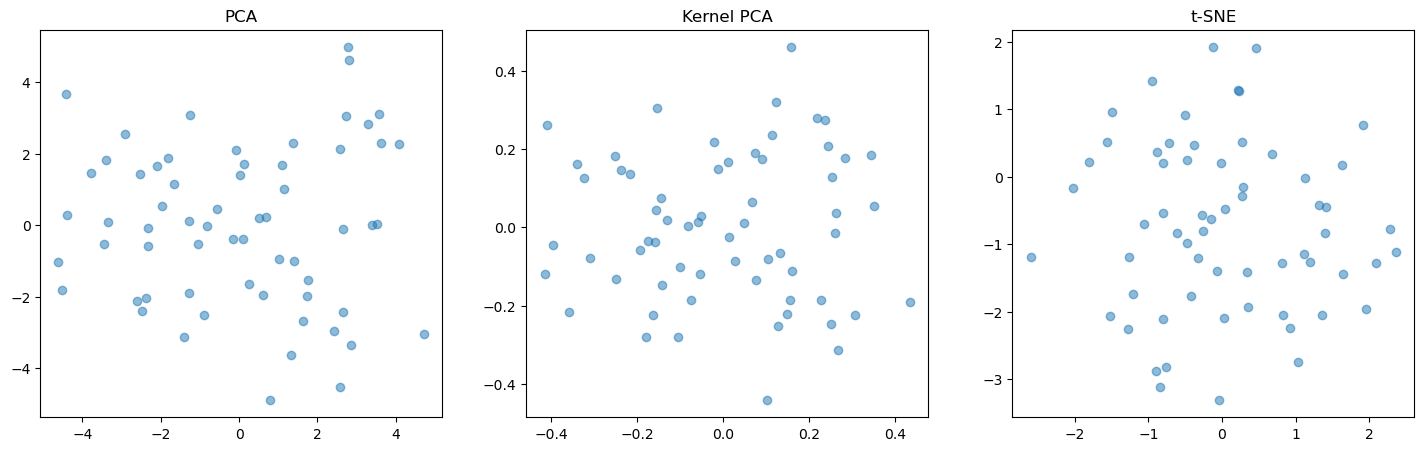

In [176]:
data_original_reduced_pca = PCA(n_components=2).fit_transform(data_scaled)
data_original_reduced_pca = pd.DataFrame(data_original_reduced_pca, columns=["Hyperparameter1", "Hyperparameter2"])

data_original_reduced_kpca = KernelPCA(n_components=2, gamma=0.02, kernel="sigmoid").fit_transform(data_scaled)
data_original_reduced_kpca = pd.DataFrame(data_original_reduced_kpca, columns=["Hyperparameter1", "Hyperparameter2"])

data_original_reduced_tsne = TSNE(perplexity=30, random_state=0).fit_transform(data_scaled)
data_original_reduced_tsne = pd.DataFrame(data_original_reduced_tsne, columns=["Hyperparameter1", "Hyperparameter2"])

fig, axes = plt.subplots(1,3, figsize=(15, 5))
fig.tight_layout(pad=3)
plt.subplot(1, 3, 1).scatter(data_original_reduced_pca["Hyperparameter1"], data_original_reduced_pca["Hyperparameter2"], alpha=0.5)
plt.subplot(1, 3, 1).set_title("PCA")
plt.subplot(1, 3, 2).scatter(data_original_reduced_kpca["Hyperparameter1"], data_original_reduced_kpca["Hyperparameter2"], alpha=0.5)
plt.subplot(1, 3, 2).set_title("Kernel PCA")
plt.subplot(1, 3, 3).scatter(data_original_reduced_tsne["Hyperparameter1"], data_original_reduced_tsne["Hyperparameter2"], alpha=0.5)
plt.subplot(1, 3, 3).set_title("t-SNE")

In [177]:
%store data_original_reduced_pca
%store data_original_reduced_kpca
%store data_original_reduced_tsne

Stored 'data_original_reduced_pca' (DataFrame)
Stored 'data_original_reduced_kpca' (DataFrame)
Stored 'data_original_reduced_tsne' (DataFrame)


# 2. Dimensionsreduzierung auf Themenbereiche

Bei der Korrelationsanalyse wurde deutlich, dass in den Datenpunkten am ehesten die Features (bzw. Antworten zu Fragen) korrelieren, die inhaltlich ähnliche Interessen abfragen. Diese Beobachtung passt auch zu der Intuition, dass Menschen sich grundsätzlich für gewisse Lebensbereiche interessieren, und Fragen zu demselben Lebensbereich im Allgemeinen ähnlich beantworten. Beispiele hierführ sind die Korrelation der Antworten zu den Fragen *"Wie sehr interessierst du dich für darstellende Künste wie Schauspiel, Tanz oder Gesang?"* und *"Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?"* mit einem Korrelationskoeffizienten von 0.7 oder der Korrelation von *"Prokrastinierst du, wenn du lernen müsstest?"* mit *"Wie häufig machst du Abgaben auf den letzten Drücker?"* mit einem Korrelationskoeffizienten von 0.5.

Ausgehend von dieser Beobachtung wäre es naheliegend bzw. denkbar, die gestellten Fragen bzw. Features inhaltlich nach bestimmten Bereichen zu gruppieren. Dadurch gehen zwar für die weiteren Untersuchungen eventuell wertvolle Korrelationen verloren, ermöglicht es aber womöglich, den Datenpunkten bzw. Personen auf eineprägnantere Weise Eigenschaften zuzuschreiben. Im Folgenden werden zunächst die Themenbereiche definiert, um dann für jeden Datenpunkt mithilfe von Lagemaßen und den bereits zuvor genutzten Algorithmen entsprechende Werte zu berechnen.

## 2.1 Vorbereitung der Daten

Da die Art und Strukturierung der Datenerhebung im Vorfeld bekannt war, können die Themenbereiche aus den Kapiteln des Fragebogen entnommen werden. Gleichzeitig lassen sich die Themenbereiche aber auch schon allein aus den Namen der Features erkennen. Letztendlich wurden die sieben Themenbereiche "Demographie", "Aktivität", "Kreativität", "Wissenschaft", "Soziales", "Studienverhalten" und "Persönlichkeit" gewählt und die Spaltennamen der jeweiligen Themenbereiche in eigenen Arrays zusammengefasst.

In [178]:
columns_encoded.keys()

Index(['alter', 'sportlichkeit', 'ernaehrung', 'essengehen', 'kochen',
       'feiern', 'musik', 'lesen', 'schauspiel', 'filme', 'malen',
       'museumsbesuche', 'videospiele', 'social_media', 'technologie',
       'astronomie', 'naturwissenschaften', 'freiwilligenarbeit', 'soziales',
       'introvertiert', 'fomo', 'spontan', 'verwirrt', 'gluecklich',
       'geduldig', 'streitlustig', 'abenteuerlustig', 'studienzweifel',
       'studium_zufriedenheit', 'akademische_laufbahn', 'lerngruppe',
       'prokrastinieren', 'letzter_druecker', 'neue_lebensmittel', 'natur',
       'reisen', 'handwerk', 'sprachnachrichten', 'geld',
       'sportarten_Basketball', 'sportarten_Bouldern/Klettern',
       'sportarten_Football', 'sportarten_Fußball', 'sportarten_Handball',
       'sportarten_Hockey', 'sportarten_Kampfsport',
       'sportarten_Leichtathletik', 'sportarten_Rennrad/Mountainbike',
       'sportarten_Schwimmen', 'sportarten_Tanzen', 'sportarten_Tennis',
       'sportarten_Volleyball', 

In [179]:
cat_demography = ("Demographie", ["alter", "studiengang_bmi", "studiengang_bmt", "studiengang_daisy",
              "studiengang_mmi", "funktion_student*in", "geschlecht_weiblich"])

cat_activity = ("Aktivität", ["sportlichkeit", "ernaehrung", "essengehen", "kochen", "feiern",
              "sportarten_Basketball",
              "sportarten_Bouldern/Klettern",
              "sportarten_Football",
              "sportarten_Fußball",
              "sportarten_Handball",
              "sportarten_Hockey",
              "sportarten_Kampfsport",
              "sportarten_Leichtathletik",
              "sportarten_Rennrad/Mountainbike",
              "sportarten_Schwimmen",
              "sportarten_Tanzen",
              "sportarten_Tennis",
              "sportarten_Volleyball",
              "sportarten_Wassersport",
              "sportarten_Wintersport",
              "sportarten_Yoga",
              "lieblingssportart_badminton",
              "lieblingssportart_basketball",
              "lieblingssportart_bouldern",
              "lieblingssportart_fußball",
              "lieblingssportart_keine_lieblingssportart",
              "lieblingssportart_tischtennis"])

cat_creativity = ("Kreativität", ["musik", "lesen", "schauspiel", "filme", "malen", "museumsbesuche",
              "lieblingsmusiker_kein_lieblingsmusiker",
              "genre_lieblingsmusiker_alternative",
              "genre_lieblingsmusiker_electro",
              "genre_lieblingsmusiker_kein_lieblingsgenre",
              "genre_lieblingsmusiker_pop",
              "genre_lieblingsmusiker_rap_hip_hop",
              "genre_lieblingsmusiker_rock"])

cat_science = ("Wissenschaft", ["videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften"])

cat_social = ("Soziales", ["freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig", "abenteuerlustig"])

cat_study = ("Studienverhalten", [ "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren", "letzter_druecker"])

cat_personality = ("Persönlichkeit", ["neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld",
              "lieblingsessen_burger",
              "lieblingsessen_döner",
              "lieblingsessen_kein_lieblingsessen",
              "lieblingsessen_lasagne",
              "lieblingsessen_pasta",
              "lieblingsessen_pfannkuchen",
              "lieblingsessen_pizza",
              "lieblingsessen_sushi"])

all_categories = [cat_demography, cat_activity, cat_creativity, cat_science, cat_social, cat_study, cat_personality]

Die folgende Hilfsmethode iteriert für ein gegebenes Datenset und einem Model (zur Dimensionsreduzierung) über die definierten Themenbereiche und füllt ein neues DataFrame, das als Features nur die Themenbereiche besitzt.

In [180]:
# Helper-method to perform dimensionality reduction for given data and reduction model on predefined categories
# Input:
#   - data: DataFrame to be reduced
#   - model: Model which is used to perform reduction; Has to support the .fit_transform()-function
# Output: DataFrame, which used the given model to reduce the data to the predefined categories

def compute_categories(data, model):
    data_reduced = pd.DataFrame(columns=[category[0] for category in all_categories])
    for category in all_categories:
        model_trained = model.fit_transform(data[[columns_encoded[x] for x in category[1]]])
        data_reduced[category[0]] = model_trained[:,0]
    return data_reduced

## 2.2 Dimensionsreduzierung über Lagemaße (arithm. Mittelwert)

Der wohl intuitivste Weg, die Features der einzelnen Themenbereiche zusammenzufassen, ist die Berechnung des (arithm.) Mittelwertes pro Datenpunkt für jeweils alle im Themenbereich enthaltenen Features. Da hierfür kein Model genutzt wird, wird die Hilfsmethode an dieser Stele (noch) nicht genutzt.

In [181]:
data_reduced_mean = pd.DataFrame(columns=[category[0] for category in all_categories])
for category in all_categories:
    dataframe_category_columns = data_encoded[[columns_encoded[cat] for cat in category[1]]]
    data_reduced_mean[category[0]] = dataframe_category_columns.mean(axis=1)

data_reduced_mean = data_reduced_mean.round(2)
data_reduced_mean

,Demographie,Aktivität,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,4.29,0.81,1.62,2.6,3.3,2.83,1.43
1,4.00,0.89,1.69,4.4,2.8,2.83,1.50
2,3.71,0.89,1.85,3.2,3.8,3.33,1.29
3,3.57,0.74,1.38,3.2,3.0,2.67,1.57
4,3.86,0.52,1.54,2.0,3.3,3.33,1.36
...,...,...,...,...,...,...,...
57,4.00,0.67,2.15,2.8,3.0,2.00,1.14
58,3.43,0.70,0.92,2.8,3.4,2.67,1.57
59,4.00,0.67,1.77,2.4,2.9,2.83,1.43
60,4.86,0.93,2.23,3.8,3.3,3.33,1.50


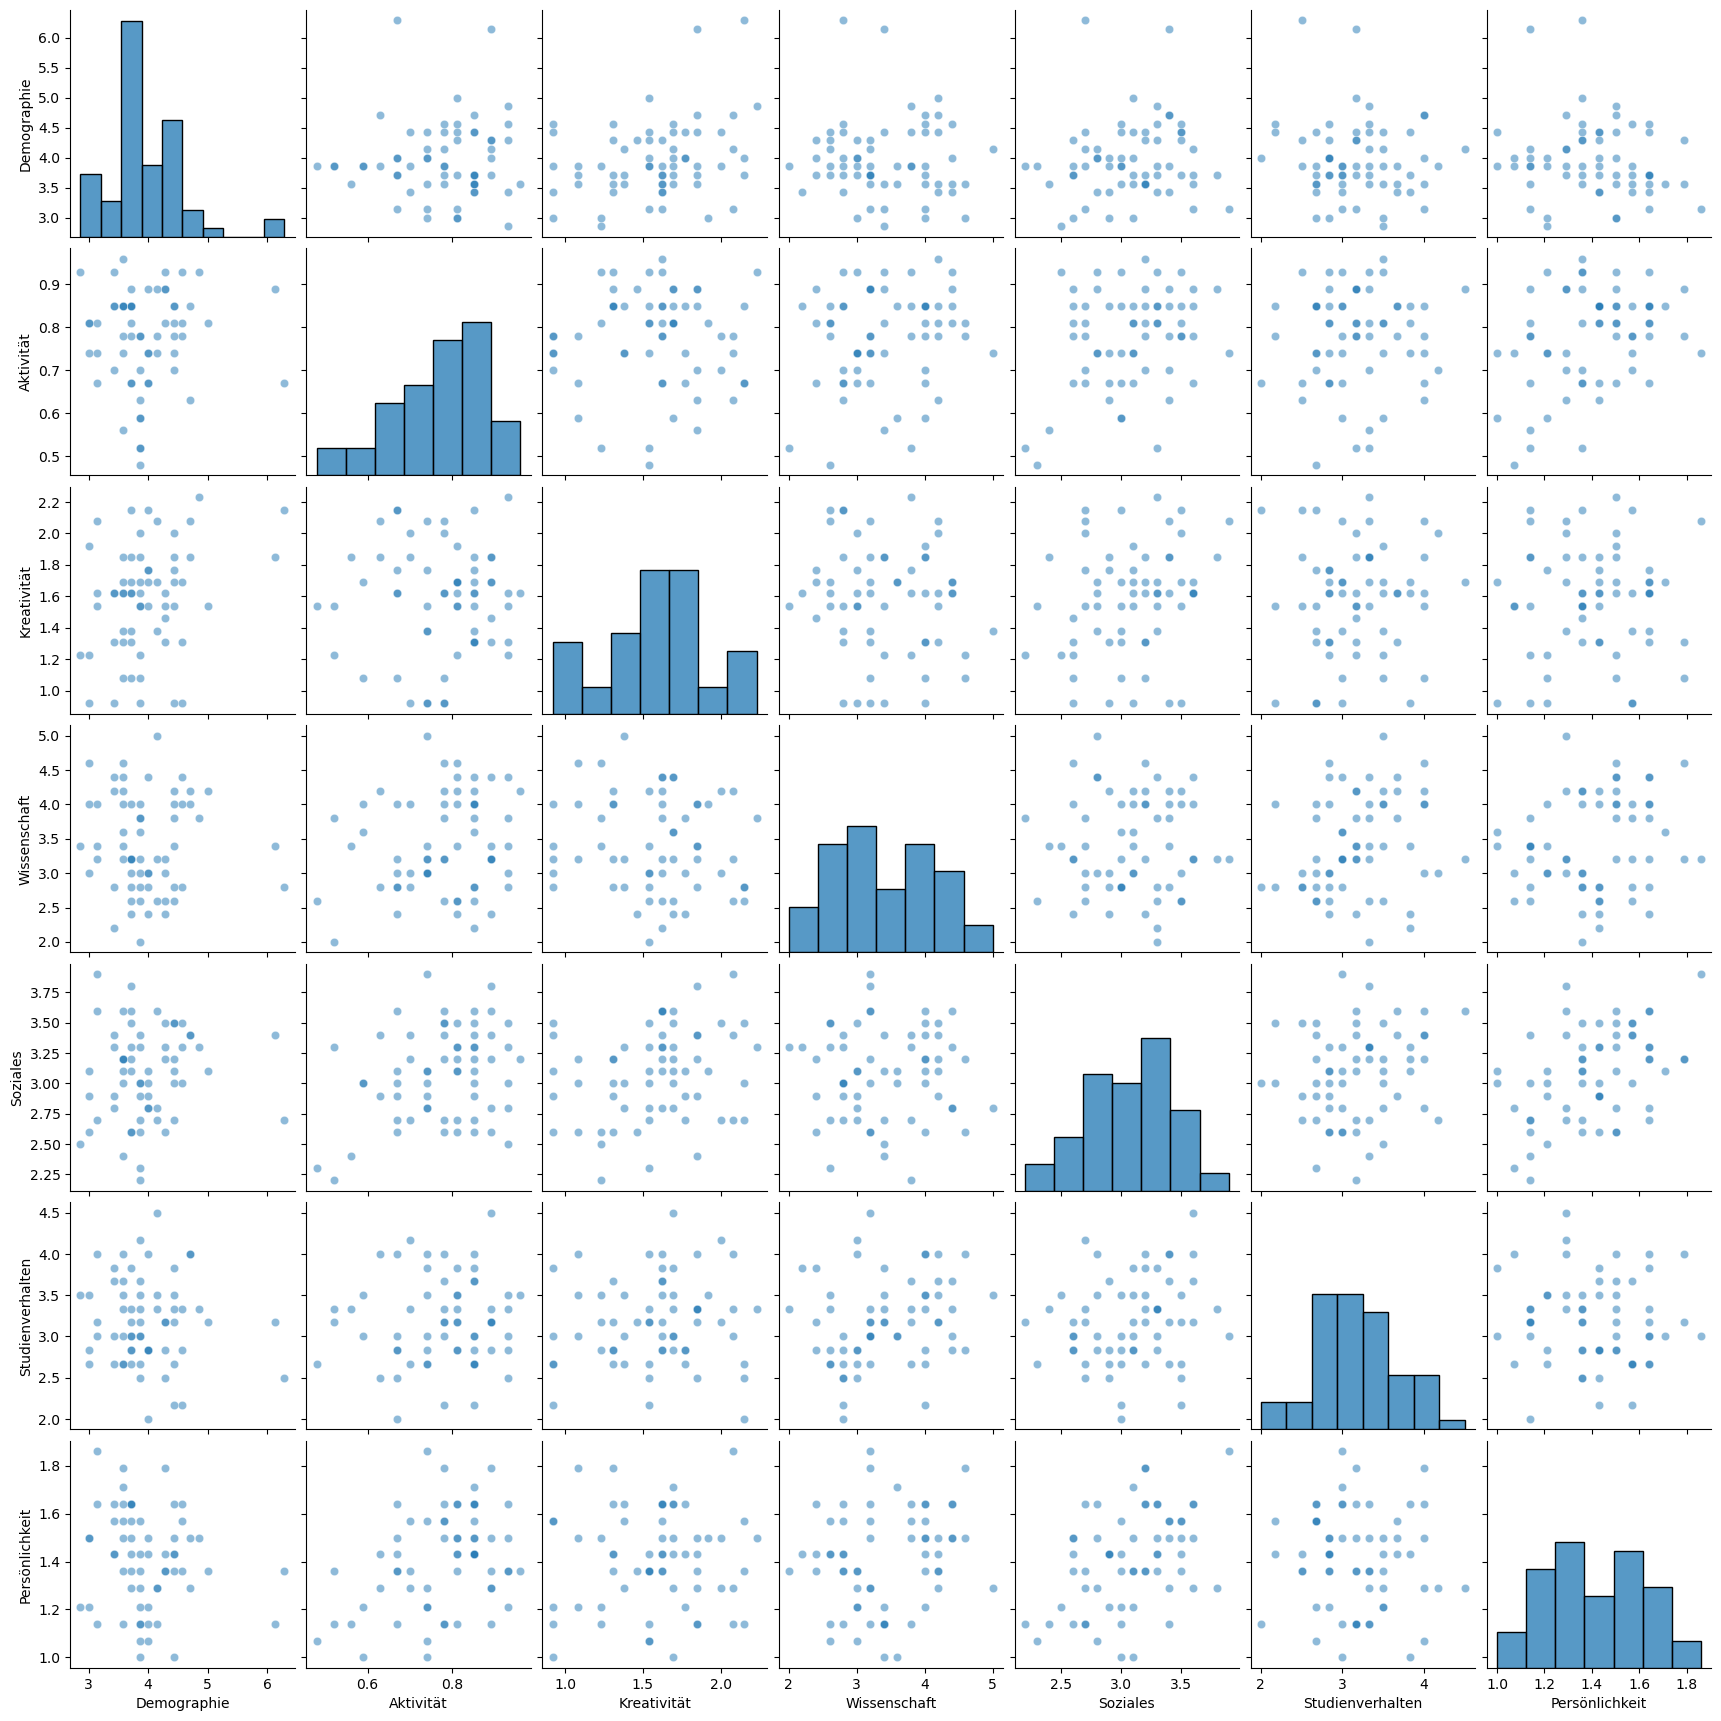

In [182]:
sb.pairplot(data_reduced_mean, plot_kws={'alpha':0.5})

### Ergebnisse / Beobachtungen
Beim Aufspannen der Datenpunkte über jeweils Paare von berechneten Themengebieten lässt sich zunächst feststellen, dass sich die Datenpunkte "gitterartig" anordnen. Das ist in der Nutzung des arithmetischen Mittelwertes als Berechnungsfunktion begründet, da pro Themenbereich aufgrund der Beschränkung auf Angaben zwischen 1-5 nur eine begrenzte Anzahl von möglichen Kombinationen an Antworten möglich war. Die berechneten Mittelwerte ordnen sich demnach auf eine handvoll berechneter Werte ein.

Da die Korrelationen vor allem innerhalb der Themengebiete zu finden waren, ist es nicht verwunderlich, dass die Themengebiete zwischeneinander wenig Strukturen erkennen lassen. Dennoch sind kleinere Zusammenhänge zu erkennen: Beispielsweise gibt es so gut wie keine Datenpunkte bzw. Personen, die einen niedrigen "Aktivitäts"-Wert, aber gleichzeitig einen hohen "Persönlichkeits"-Wert besitzen. Da das Themenfeld "Persönlichkeit" auch Fragen nach Reisen und Zeit in der Natur abfragt, erscheint diese Schlussfolgerung plausibel.

Die einzige Ausnahme bei der "gitterartigen" Anordnung bildet das Themenfeld "Demographie", da hier durch die freie Eingabe eines Alters ein größerer Zahlenraum zur Auswahl stand. So sind in der ersten Spalte (bzw. Zeile) zwei Ausreißer zu erkennen, die einen "Demographie"-Wert über 4 zugewiesen bekommen haben. Zur näheren Untersuchung werden die Indizies ausgelesen und die ursprünglichen Daten ausgegeben.

In [183]:
mask_age_cluster1 = data_reduced_mean[cat_demography[0]] > 5.5
data_reduced_mean[mask_age_cluster1]

,Demographie,Aktivität,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
6,6.29,0.67,2.15,2.8,2.7,2.50,1.36
8,6.14,0.89,1.85,3.4,3.4,3.17,1.14


In [184]:
data_encoded.loc[[6, 8]]

,Alter,Als wie sportlich würdest du dich einschätzen?,Welche Rolle spielt für dich gesunde Ernährung?,Wie gerne gehst du Essen oder Trinken?,Wie gerne kochst du selbst?,Wie gerne gehst du feiern?,Wie sehr interessierst du dich für Musik?,Wie gerne liest Du?,"Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?","Wie sehr interessierst du sich für Filme, Kino, Fernsehsendungen?",...,Studiengang Daisy? (encoded),Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Genre Lieblingsmusiker Alternative? (encoded),Genre Lieblingsmusiker Electro? (encoded),Genre Lieblingsmusiker Kein Lieblingsgenre? (encoded),Genre Lieblingsmusiker Pop? (encoded),Genre Lieblingsmusiker Rap Hip Hop? (encoded),Genre Lieblingsmusiker Rock? (encoded),Geschlecht (weiblich?)
6,41,3,2,5,3,3,5,4,5,5,...,0,1,1,0,0,0,1,0,0,1
8,42,3,3,5,5,3,4,4,4,3,...,1,0,0,0,0,0,0,1,0,0


Wie vermutet, handelt es sich bei den beiden Datenpunkten um die Personen mit dem höchsten Alter. Die Nutzung des arithmetischen Mittels zur Berechnung der reduzierten Werte scheint also der Intuition zu folgen.

In [185]:
%store data_reduced_mean

Stored 'data_reduced_mean' (DataFrame)


## 2.3 PCA

Ein Nachteil der Berechnung über das arithmetische Mittel ist, dass alle enthaltenen Features gleich gewichtet werden, insbesondere wenn etwa durch das One-Hot-Encoding von Sportarten und Genres unverhältnismäßig viele Feature hinzugezogen werden, die häufig den Wert "0" enthalten und die Berechnung somit ggf. verfälschen. Deshalb wird im Folgenden mithilfe des PCA versucht, die Werte auf komplexere Art berechnen zu lassen. Da die zu berechnende Dimension pro Themenbereich 1 ist, wird der Parameter "n_components" jeweils auf 1 gesetzt.

In [186]:
pca = PCA(n_components=1)

data_reduced_PCA = compute_categories(data_scaled, pca)
data_reduced_PCA

,Demographie,Aktivität,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,0.579667,-0.467679,-0.506995,-1.481797,0.405950,-1.635010,-0.420644
1,0.320618,-1.031154,-1.151412,1.617876,-0.517746,-1.494638,0.395413
2,0.061569,2.739008,-1.689516,-0.669291,-1.797866,-1.035561,1.817699
3,-0.067956,-0.233852,2.939717,0.105325,0.121731,-0.903822,-0.274411
4,-0.010687,0.318784,2.529134,-2.294303,-0.164162,2.018491,0.070244
...,...,...,...,...,...,...,...
57,0.320618,2.742566,-2.765588,-1.345619,-0.158858,-2.657732,-0.404015
58,-0.811401,-0.331900,4.503984,-1.985446,0.103726,0.038180,-1.398660
59,-0.495083,-0.190553,-0.948319,-1.918051,-0.498246,1.668469,-1.679744
60,2.051874,0.486303,-3.152535,1.385794,-0.388389,-1.960236,-1.198377


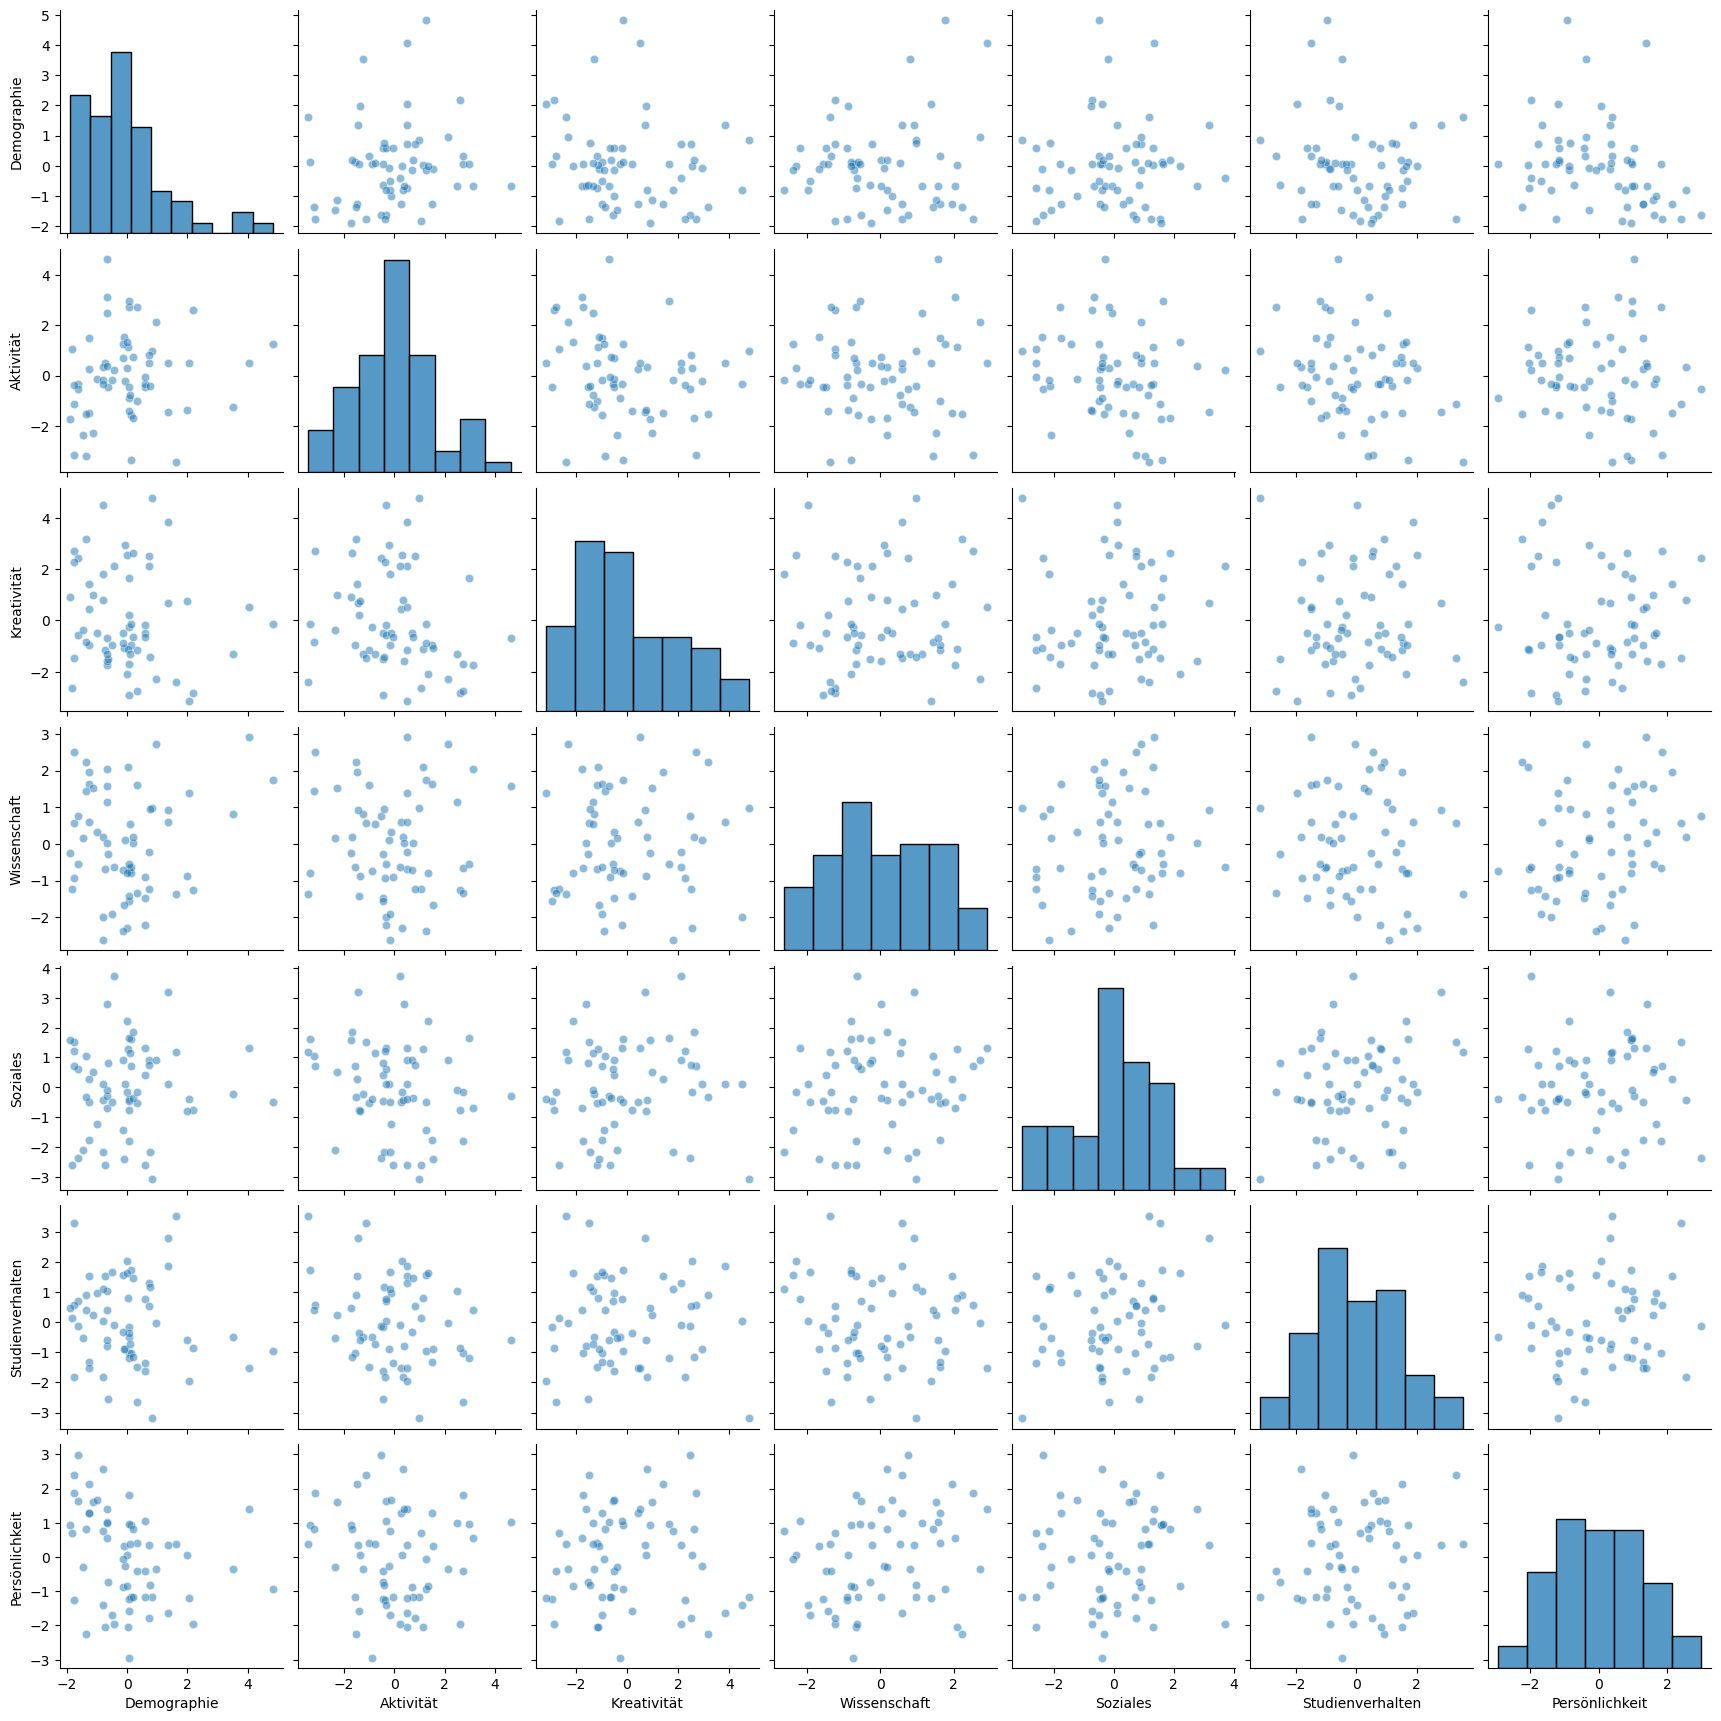

In [187]:
sb.pairplot(data_reduced_PCA, plot_kws={'alpha':0.5})

### Ergebnisse / Beobachtungen
Im Gegensatz zur Berechnung über das arithmetische Mittel sind die Datenpunkte nun deutlich mehr gestreut. Auch hier sind im Themenbereich "Demographie" wieder die charakteristischen Ausreißer zu erkennen. Ansonsten lassen sich voerst keine weiteren Aussagen über die berechneten Dimensionen treffen., der sich in drei clusterartige Strukturen zu gliedern scheint. Zunächst werden diese nur oberflächlich untersucht, und in der Clusteranalyse noch einmal aufgegriffen.

In [188]:
%store data_reduced_pca

UsageError: Unknown variable 'data_reduced_pca'


## 2.4 Kernel PCA

Nach dem gleichen Vorgehen werden die Themenbereiche nun mit Kernel PCA berechnet. Hier ergibt sich das Problem, dass die Konfiguration der benötigten Parameter (bis auf "n_components")  nicht intuitiv ersichtlich ist. Da als Ergebnis zudem sieben Dimensionen (bzw. Features) erzeugt werden, ist ein Vergleich der Ergebnisse mit verschiedenen Parametern nicht wirklich möglich. Stattdessen werden der Kernel "rbf" und der Default-Wert für den Parameter "gamma" genutzt, da diese bei der bisherigen Untersuchung zufriedenstellende Ergebnisse lieferten.

In [189]:
kpca = KernelPCA(n_components=1, kernel="rbf")

data_reduced_kPCA = compute_categories(data_scaled, kpca)
data_reduced_kPCA

,Demographie,Aktivität,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,-0.587912,0.113878,-0.163038,-0.585440,-0.065196,-0.396560,0.373343
1,-0.581340,-0.012626,-0.209293,0.571401,-0.064866,-0.483487,0.385278
2,-0.537711,-0.167822,-0.159163,-0.337822,-0.356242,-0.048434,-0.285392
3,-0.503817,-0.162075,0.669983,-0.047036,0.134251,-0.401802,0.022157
4,-0.339019,0.262010,0.598719,-0.366644,0.054083,0.340576,0.180989
...,...,...,...,...,...,...,...
57,-0.581340,-0.184468,-0.336014,-0.399189,0.235023,-0.441265,0.291530
58,0.143517,0.143899,0.588137,-0.131034,-0.176859,-0.001201,-0.204739
59,0.117564,0.295017,-0.366790,-0.270147,-0.063746,0.293460,0.475380
60,0.073284,0.244054,-0.192456,0.333350,-0.011156,-0.313788,0.582839


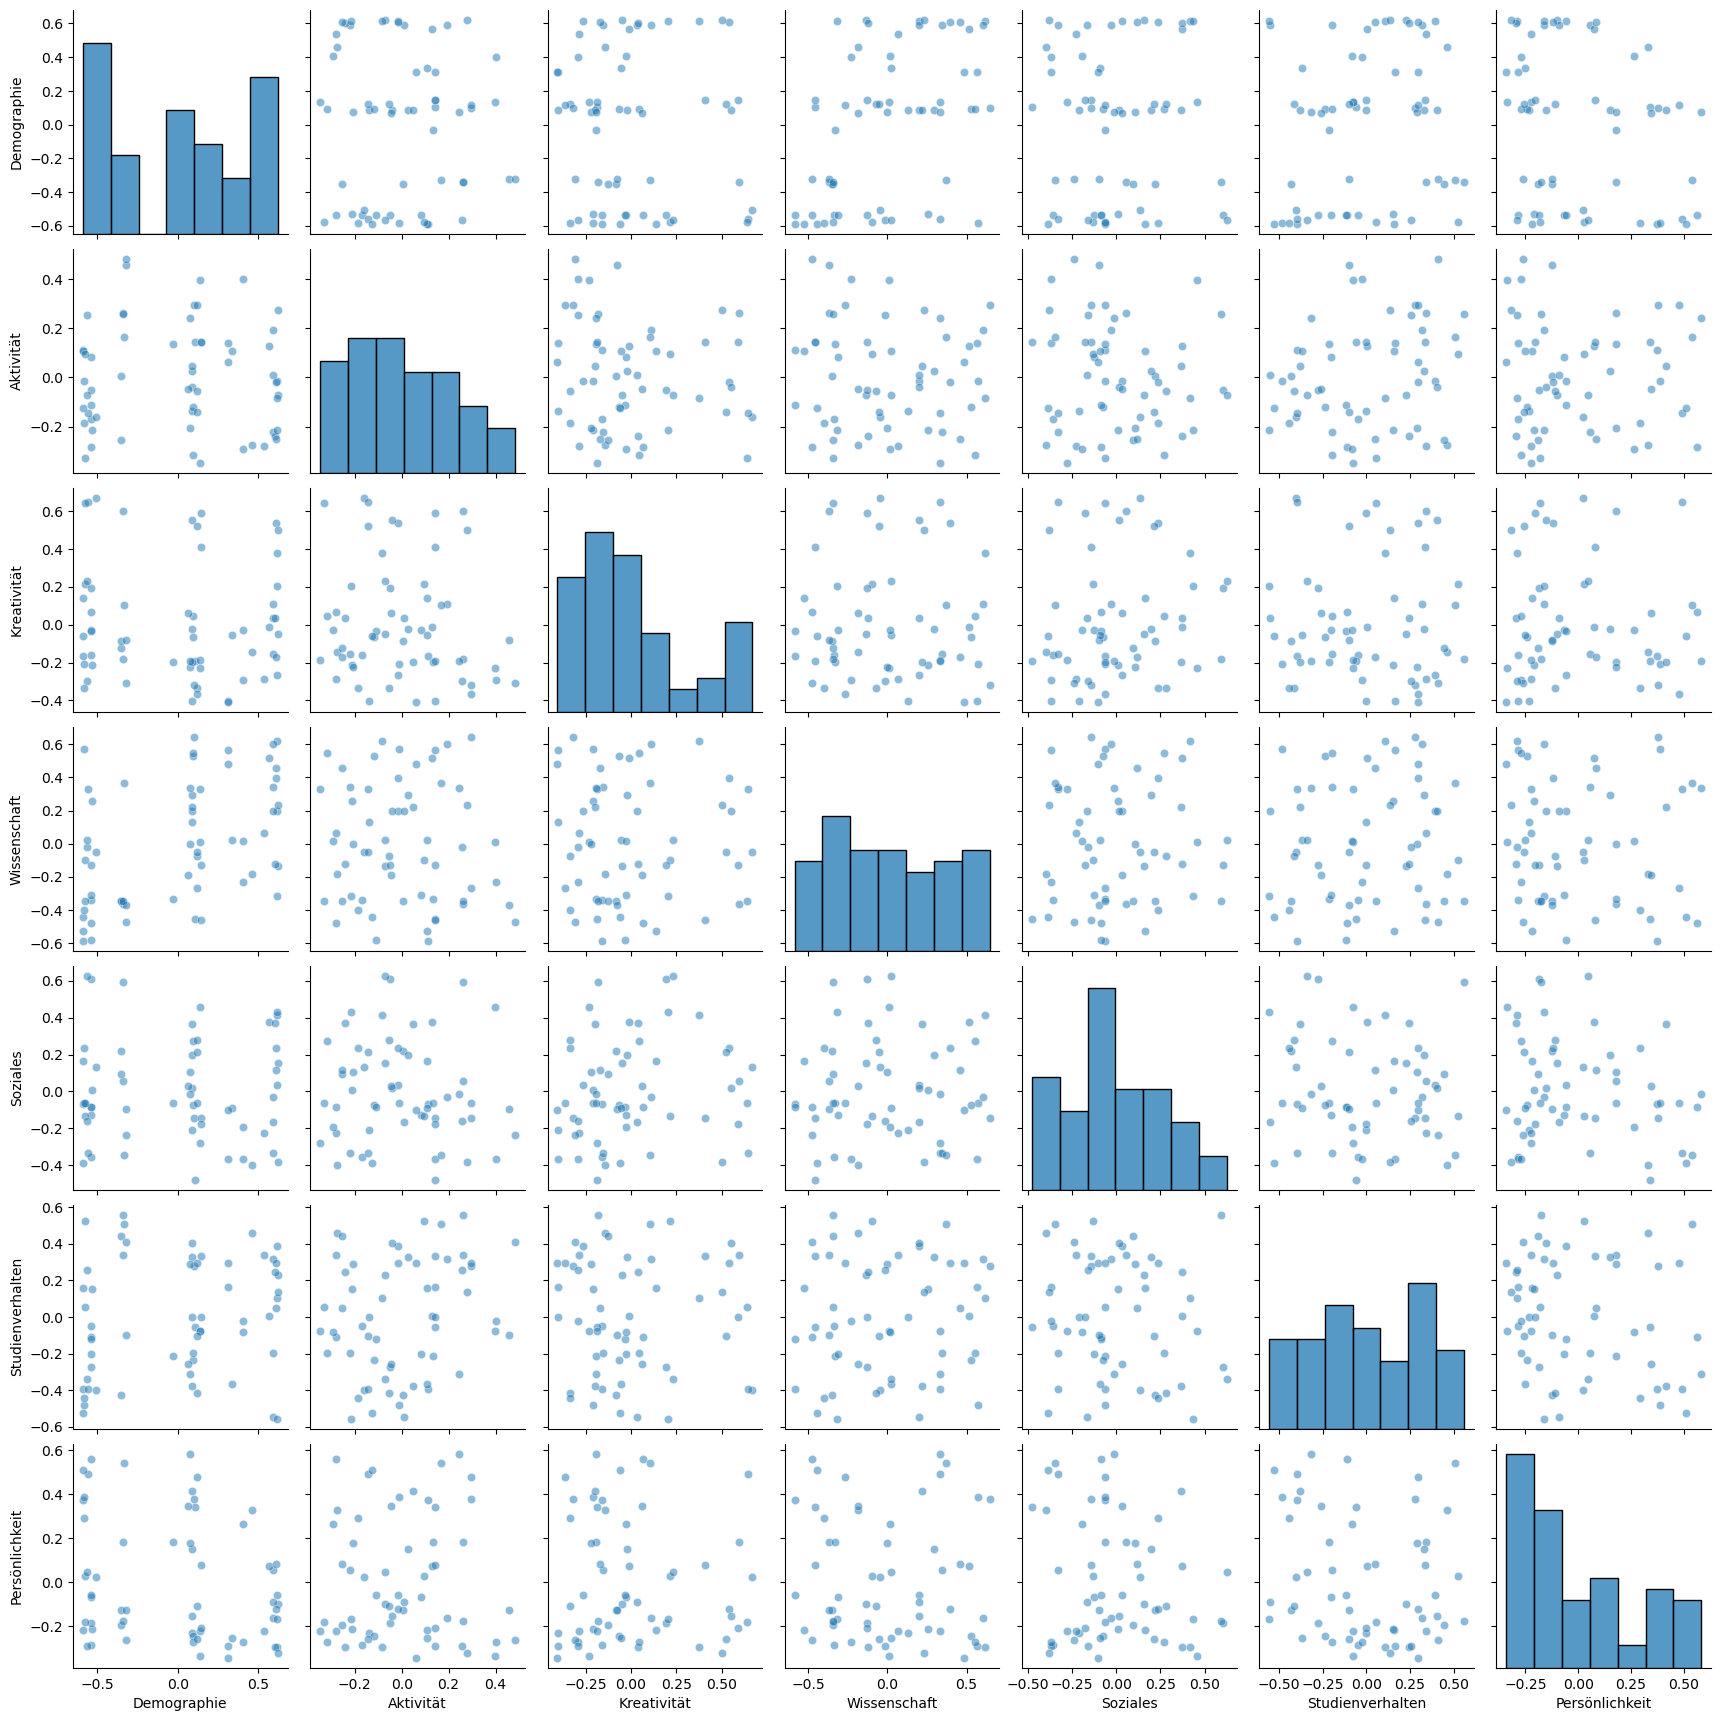

In [190]:
sb.pairplot(data_reduced_kPCA, plot_kws={'alpha':0.5})

Ähnlich zu PCA sind die Datenpunkte relativ stark gestreut. Hier fällt vor allem der Themenbereich "Demographie" auf, der sich in drei clusterartige Strukturen zu gliedern scheint. Diese werden hier noch einmal näher untersucht, indem die Daten bei den "Demographie"-Werten -0.25 und 0.25 getrennt werden.

In [191]:
mask_age_cluster1 = data_reduced_PCA[cat_demography[0]] < -0.25
mask_age_cluster2 = (data_reduced_PCA[cat_demography[0]] >= -0.25) & (data_reduced_PCA[cat_demography[0]] <= 0.25)
mask_age_cluster3 = data_reduced_PCA[cat_demography[0]] > 0.25

data_reduced_PCA_mask1 = data_reduced_PCA[mask_age_cluster1]
data_reduced_PCA_mask2 = data_reduced_PCA[mask_age_cluster2]
data_reduced_PCA_mask3 = data_reduced_PCA[mask_age_cluster3]

In [192]:
data_reduced_PCA_c1 = data_encoded.iloc[data_reduced_PCA_mask1.index]
data_reduced_PCA_c2 = data_encoded.iloc[data_reduced_PCA_mask2.index]
data_reduced_PCA_c3 = data_encoded.iloc[data_reduced_PCA_mask3.index]

data_reduced_PCA_c1 = data_reduced_PCA_c1[[columns_encoded[cat] for cat in cat_demography[1]]]
data_reduced_PCA_c2 = data_reduced_PCA_c2[[columns_encoded[cat] for cat in cat_demography[1]]]
data_reduced_PCA_c3 = data_reduced_PCA_c3[[columns_encoded[cat] for cat in cat_demography[1]]]

In [193]:
data_reduced_PCA_c1.describe()

,Alter,Studiengang Bmi? (encoded),Studiengang Bmt? (encoded),Studiengang Daisy? (encoded),Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Geschlecht (weiblich?)
count,26.000000,26.0,26.000000,26.000000,26.0,26.0,26.000000
mean,22.769231,0.0,0.269231,0.730769,0.0,1.0,0.269231
std,2.874824,0.0,0.452344,0.452344,0.0,0.0,0.452344
min,18.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000
25%,20.500000,0.0,0.000000,0.250000,0.0,1.0,0.000000
50%,23.000000,0.0,0.000000,1.000000,0.0,1.0,0.000000
75%,24.750000,0.0,0.750000,1.000000,0.0,1.0,0.750000
max,28.000000,0.0,1.000000,1.000000,0.0,1.0,1.000000


In [194]:
data_reduced_PCA_c2.describe()

,Alter,Studiengang Bmi? (encoded),Studiengang Bmt? (encoded),Studiengang Daisy? (encoded),Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Geschlecht (weiblich?)
count,17.000000,17.0,17.000000,17.0,17.000000,17.0,17.000000
mean,24.882353,0.0,0.176471,0.0,0.823529,1.0,0.470588
std,1.932691,0.0,0.392953,0.0,0.392953,0.0,0.514496
min,23.000000,0.0,0.000000,0.0,0.000000,1.0,0.000000
25%,24.000000,0.0,0.000000,0.0,1.000000,1.0,0.000000
50%,24.000000,0.0,0.000000,0.0,1.000000,1.0,0.000000
75%,25.000000,0.0,0.000000,0.0,1.000000,1.0,1.000000
max,29.000000,0.0,1.000000,0.0,1.000000,1.0,1.000000


In [195]:
data_reduced_PCA_c3.describe()

,Alter,Studiengang Bmi? (encoded),Studiengang Bmt? (encoded),Studiengang Daisy? (encoded),Studiengang Mmi? (encoded),Funktion Student*In? (encoded),Geschlecht (weiblich?)
count,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000
mean,29.894737,0.368421,0.0,0.052632,0.578947,0.842105,0.157895
std,4.665413,0.495595,0.0,0.229416,0.507257,0.374634,0.374634
min,25.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,27.500000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
50%,29.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000
75%,30.500000,1.000000,0.0,0.000000,1.000000,1.000000,0.000000
max,42.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### Ergebnisse / Beobachtungen
Anhand der Plots und der näheren Ausgabe der drei getrennten Datenmengen ist zu erkennen, dass Kernel PCA insb. innerhalb des Themenfeldes "Demographie" die Datenpunkte systematisch getrennt hat. So befinden sich im "Cluster 3", in dem alle Datenpunkte mit "Demographie"-Werten über 0.25 zu finden sind, alle BMI-Student*innen und nicht-Studierenden wie z. B. Dozent\*innen. Im "Cluster 2" befinden sich hingegen ein Großteil der MMI-Studierenden, während "Cluster 1" einen Großteil der DAISY-Studierenden beinhaltet. Diese Erkenntnisse werden in der Cluster-Analyse noch einmal aufgegriffen.

In [196]:
%store data_reduced_kpca

UsageError: Unknown variable 'data_reduced_kpca'


## 2.5 t-SNE

Ähnlich wie bei dem Vorgehen für Kernel PCA wird auch für t-SNE der Parameter "n_components" auf 1 gesetzt, und der "perplexity"-Parameter basierend auf den Erfahrungen aus Kapitel 1 mit dem Default-Wert 30 genutzt.

In [197]:
tsne = TSNE(n_components=1, random_state=0)

data_topics_reduced_tsne = compute_categories(data_scaled, tsne)
data_topics_reduced_tsne

,Demographie,Aktivität,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,-3.119780,-1.055389,2.217844,-2.102802,-0.963761,-3.017568,-7.478622
1,-3.277016,-2.011001,2.207144,1.051564,-1.216722,-3.530753,-7.129253
2,-3.574540,-0.677306,1.129414,-1.477640,-2.521754,-2.743463,-4.196132
3,-3.672833,0.086896,-3.992240,-0.471056,0.083891,-3.484990,-8.414960
4,-2.037802,-0.701284,3.326317,-2.755713,-0.496484,0.512413,-7.096321
...,...,...,...,...,...,...,...
57,-3.277016,-2.698035,-0.890709,-2.830156,0.469239,-3.776809,-6.906602
58,-0.627089,-1.988870,-4.318157,-2.482596,-1.944232,-1.471967,-9.284055
59,-0.178868,-1.112061,-0.552818,-2.122269,-0.663276,0.439378,-7.686540
60,2.452790,-1.228287,-1.732396,1.443937,-1.041870,-3.094434,-7.554065


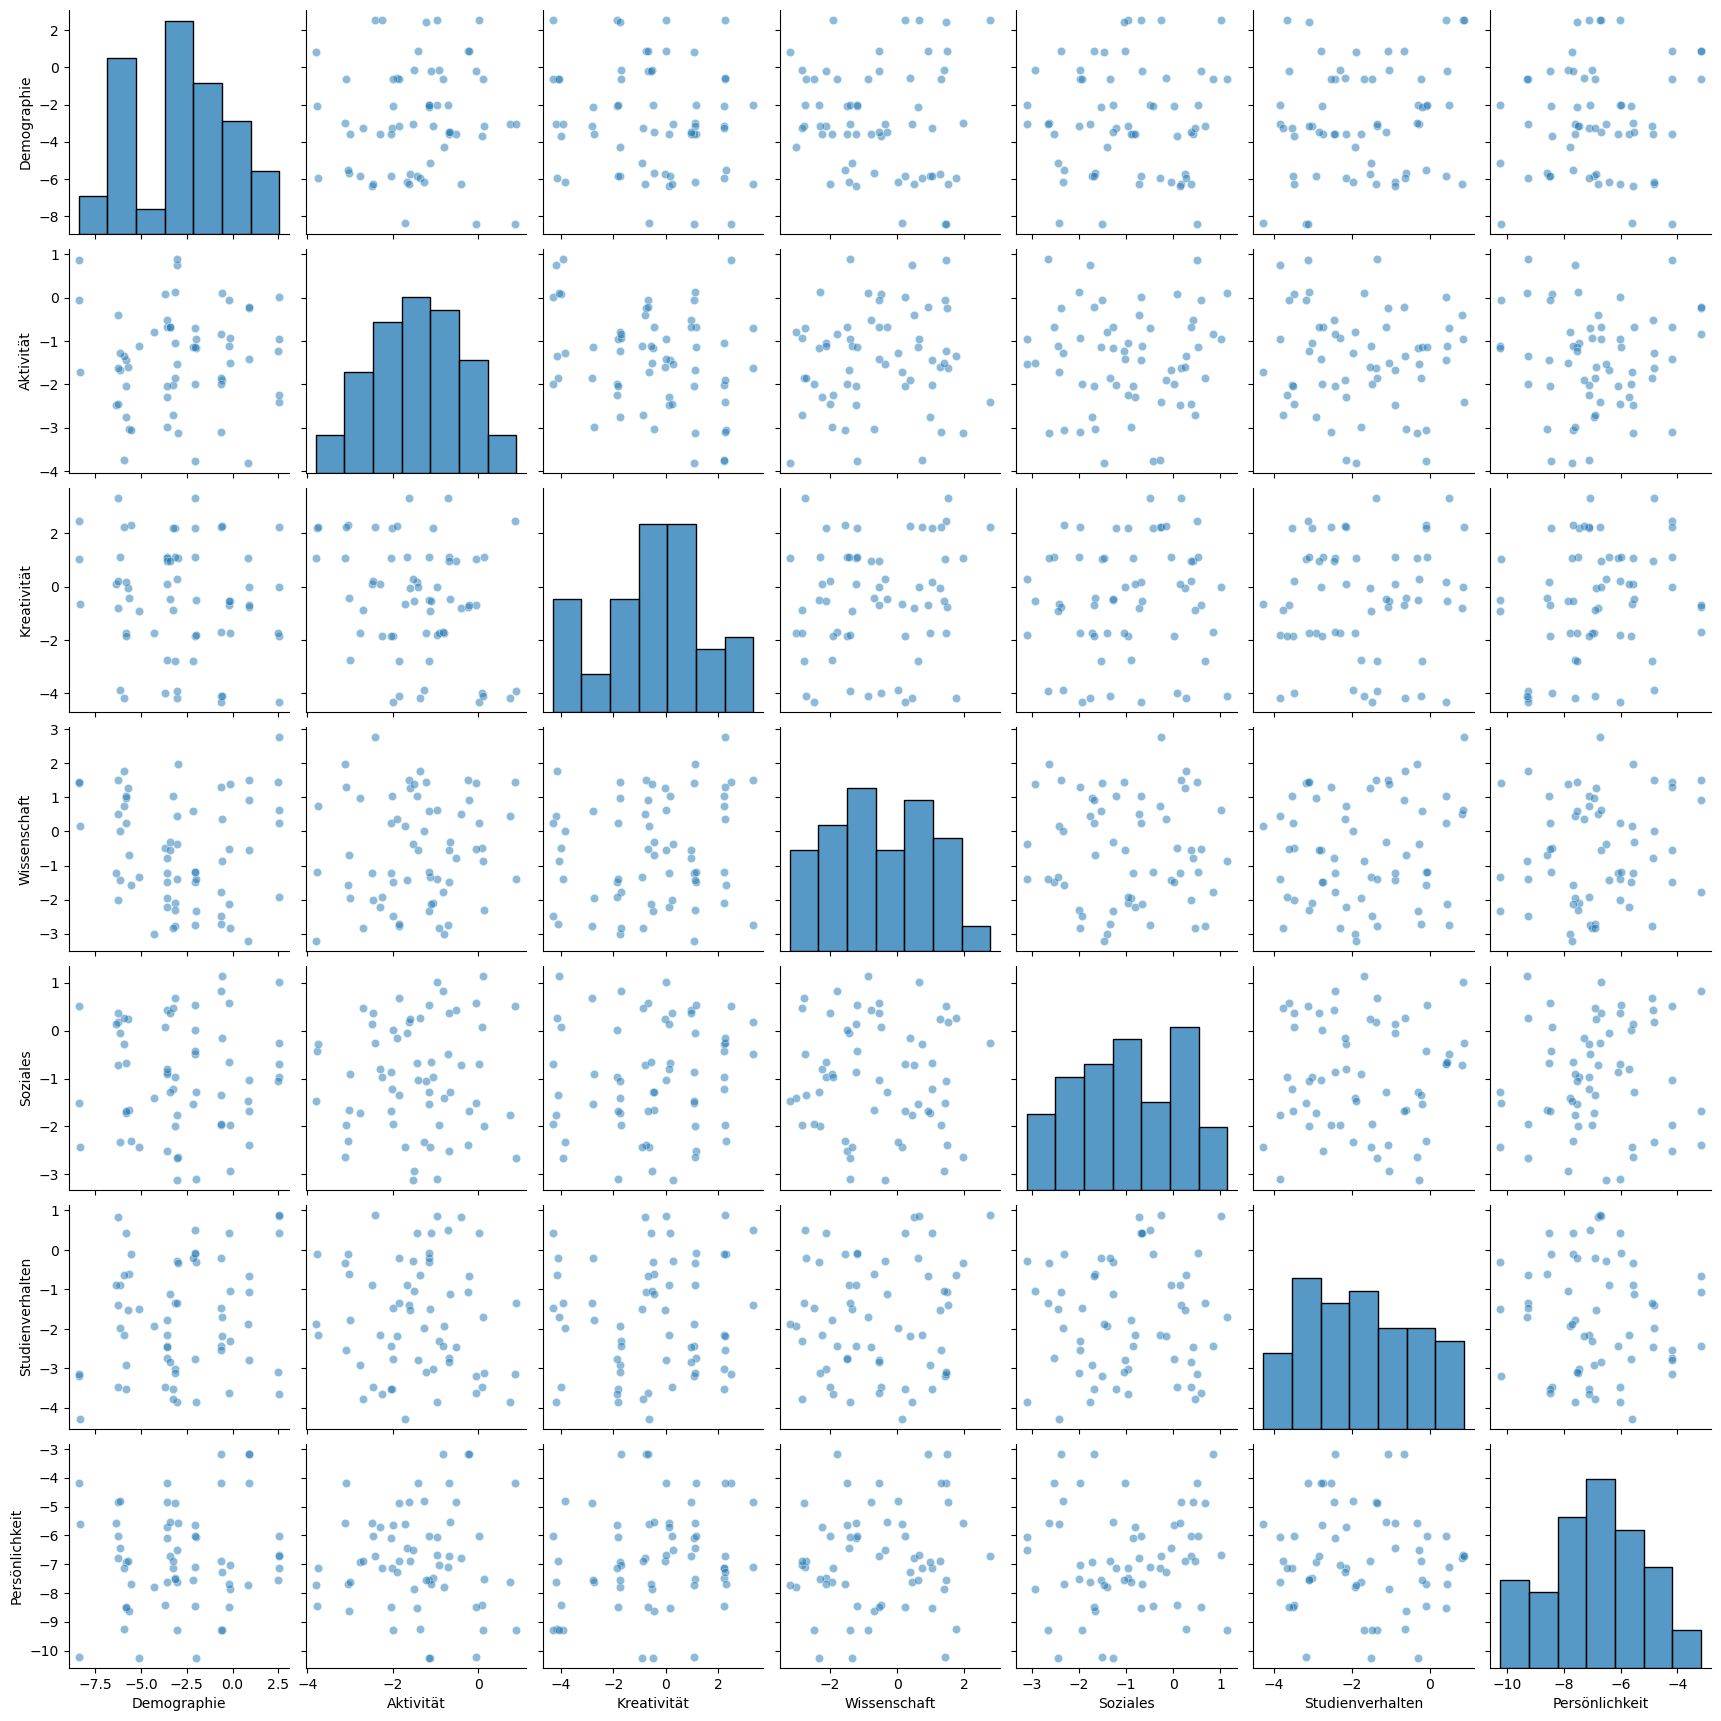

In [198]:
sb.pairplot(data_topics_reduced_tsne, plot_kws={'alpha':0.5})

### Ergebnisse / Beobachtungen
- Ähnlich zu den Ergebnissen von (Kernel) PCA sind die Daten gestreut, wobei in einigen Plots kleinere Strukturen zu erkennen sind. Da diese aber weniger ausgeprägt sind als bspw. die Trennung der "Demographie"-Werte im (Kernel) PCA, werden die Ergebnisse vorerst nicht weiter untersucht.

In [199]:
%store data_topics_reduced_tsne

Stored 'data_topics_reduced_tsne' (DataFrame)
